#### LangGraph workflow that integrates external tools (e.g., web search) into a stateful, graph-based conversational agent. 
#### The agent can decide   when to use a tool node and when to respond   directly, based on the conversation state.

In [8]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from pydantic import BaseModel
from dotenv import load_dotenv
from langchain.agents import Tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

In [9]:
# This script demonstrates a LangGraph workflow that integrates external tools (e.g., web search)
# into a stateful, graph-based conversational agent. The agent can decide when to use a tool node
# and when to respond directly, based on the conversation state.

In [10]:
load_dotenv()

True

In [4]:
# Setup Tools
# Instantiate a Google Serper API wrapper for web search
serper = GoogleSerperAPIWrapper()
# Define a LangChain Tool for online search
tool_search = Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )

# List of available tools for the agent
tools = [tool_search]

# Helper function to get an LLM instance by model name
def get_llm(model_name: str):
    if model_name == "gpt":
        return ChatOpenAI(model="gpt-4o-mini")  # Use OpenAI GPT model
    elif model_name == "llama":
        return ChatOllama(model="llama3.2:1b")  # Use local Ollama Llama model




In [11]:
## Step 1. Define State
class State(BaseModel):
    # The state holds a list of messages. The add_messages reducer will append new messages to this list.
    messages: Annotated[list, add_messages]

In [ ]:
#setup llm and bind tools
llm = get_llm("gpt")
llm_with_tools = llm.bind_tools(tools)

## Step 2 -> start graph builder
graph_builder = StateGraph(State)

## Step 3 -> Define Nodes
def chatbot(state: State) -> State:
    new_messages = [llm_with_tools.invoke(state.messages)]
    return State(messages=new_messages)

## add nodes to graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


##Step 4 -> create edge
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


##Step 5 -> compile graph
graph = graph_builder.compile()

##Step 6 -> create entry for chat and invoke graph
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content



##Step 7 -> Accept user input and invoke graph
while True:
    user_input = input("Enter your message: ")
    if user_input.strip().lower() in ["exit", "bye"]:
        print("Goodbye!")
        break
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    print(f"AI: {result['messages'][-1].content}")


Enter your message:  I am John, introduce yourself


AI: Hello John! I'm an AI here to assist you with information, answer questions, and help with a variety of tasks. How can I assist you today?


Enter your message:  What is capital of France


AI: The capital of France is Paris.


Enter your message:  What is my name


AI: I don't have access to personal information about you unless you've shared it during our conversation. If you'd like me to know your name, please tell me!


### Display graph

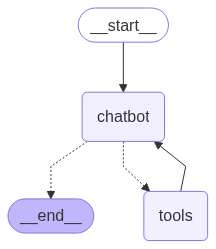

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))